In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception

In [ ]:
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 15
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
TRAIN_DIRECTORY = "big-files/train/"
TEST_DIRECTORY = "big-files/test/"
VALIDATION_DIRECTORY = "big-files/validation/"
CLASS_LABELS = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
# классы


In [ ]:
test_directory = os.listdir(TEST_DIRECTORY)


In [42]:
# Создаем списки для хранения данных
filename = []
labels = []

# Проходим по каждому классу и добавляем данные в списки
def create_dataframe(data_dir, class_labels):
    for category, label in class_labels.items():
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            filename.append(img_path)
            labels.append(label)
    
# создаем DataFrame
    return pd.DataFrame ({
        "filename": filename,
        "category": labels
        })

In [43]:
df = create_dataframe(TRAIN_DIRECTORY, CLASS_LABELS)
df_validation = create_dataframe(VALIDATION_DIRECTORY, CLASS_LABELS)

test_df = pd.DataFrame({
    "filename": test_directory
})

<Axes: xlabel='category'>

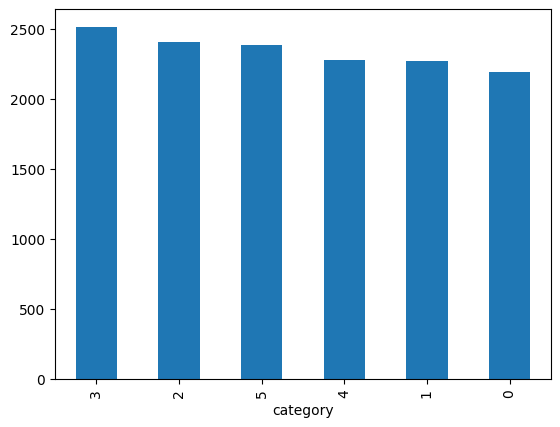

In [44]:
df["category"].value_counts().plot.bar()

In [45]:
df_validation["category"].value_counts()

category
3    3037
2    2957
5    2883
4    2784
1    2745
0    2628
Name: count, dtype: int64

In [46]:
df['category'] = df['category'].astype(str)
df_validation['category'] = df_validation['category'].astype(str)

In [47]:
model_conv = Xception(weights = "imagenet",
                 include_top = False,
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

In [48]:
model_conv.trainable = False

In [49]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # для нормализации пикселей изображения в диапазоне [0, 1].
)

In [50]:
val_datagen = ImageDataGenerator(
    rescale=1/255
)

In [51]:
test_datagen = ImageDataGenerator(
    rescale=1./255 
    )

In [52]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='categorical',
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_validation,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIRECTORY,
    x_col="filename",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
)

Found 14034 validated image filenames belonging to 6 classes.
Found 17034 validated image filenames belonging to 6 classes.
Found 7301 validated image filenames.


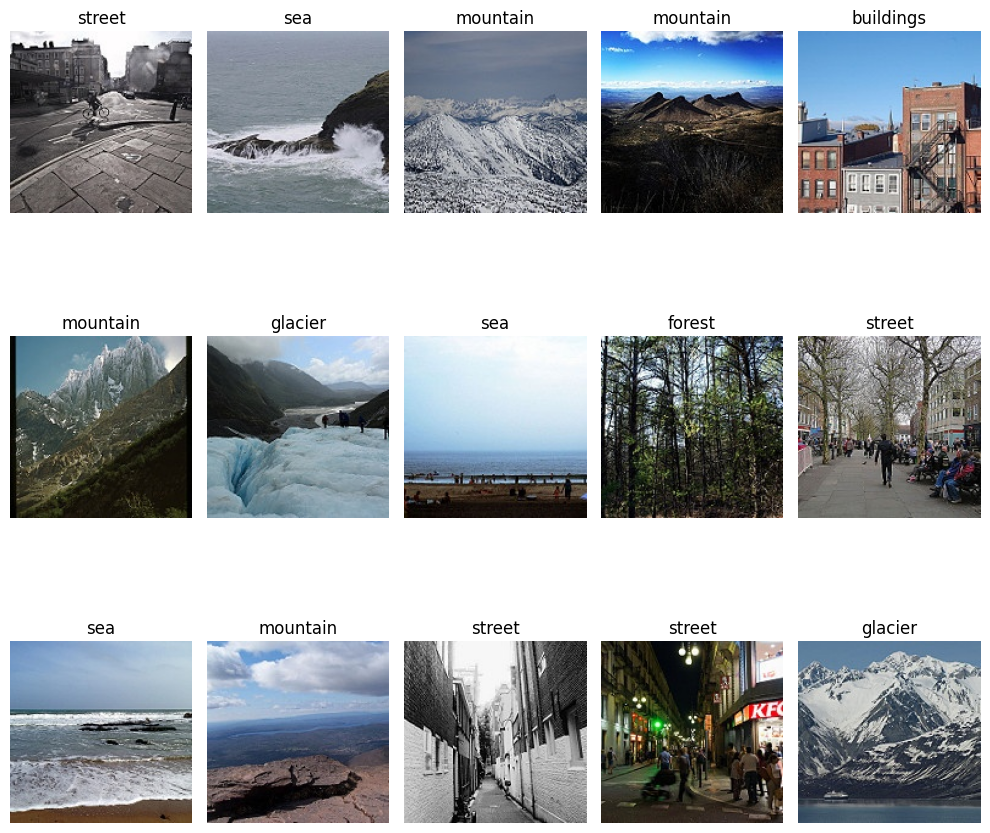

In [53]:
# Создаем обратный словарь
reverse_class_labels = {v: k for k, v in CLASS_LABELS.items()}

fig, axes = plt.subplots(3, 5, figsize=(10, 10))
for i in range(3):
    for j in range(5):
        images, labels = next(train_generator)
        axes[i, j].imshow(images[0])
        axes[i, j].axis('off')
        label_idx = np.argmax(labels[0])
        label_name = reverse_class_labels[label_idx]
        axes[i, j].set_title(label_name)
        
plt.tight_layout()
plt.show()

In [54]:
model = Sequential([
    model_conv,
    Flatten(),
    Dropout(0.3),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(6, activation="softmax") # у нас 6 классов
])




In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)


earlystop = EarlyStopping(patience = 5)
    
callbacks = [earlystop, learning_rate_reduction]

In [56]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [57]:
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
)

Epoch 1/15


c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - acc: 0.5469 - loss: 12.2681 - val_acc: 0.8164 - val_loss: 5.0864
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - acc: 0.8025 - loss: 6.4324 - val_acc: 0.8477 - val_loss: 4.3363
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - acc: 0.8059 - loss: 3.9637 - val_acc: 0.8320 - val_loss: 3.0892
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - acc: 0.8639 - loss: 3.2009 - val_acc: 0.8945 - val_loss: 1.7226
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - acc: 0.8819 - loss: 1.7414 - val_acc: 0.8730 - val_loss: 1.3167
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - acc: 0.8330 - loss: 2.1309 - val_acc: 0.8711 - val_loss: 1.2311
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - acc: 0.8620 - loss: 1.3846 - val_acc: 0.9062 - val_loss: 1.0277
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - acc: 0.8351 - loss: 1.3469 - val_acc: 0.8594 - val_loss: 1.1556
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - acc: 0.8480 - loss: 0.7959 - v

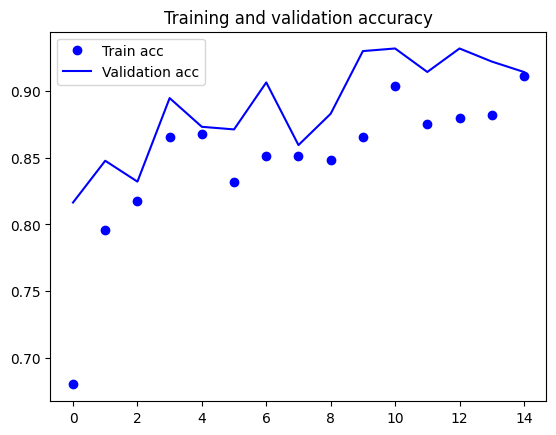

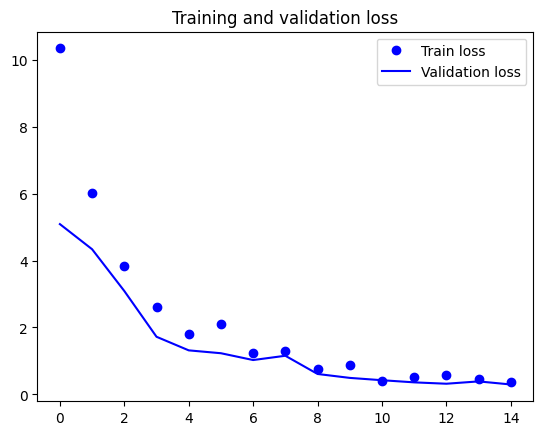

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(acc, 'bo', label='Train acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [59]:
pred = model.predict(test_generator)

229/229 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step


In [60]:
predicted_classes = np.argmax(pred, axis=1)

In [61]:
test_df["category"] = predicted_classes

<Axes: xlabel='category'>

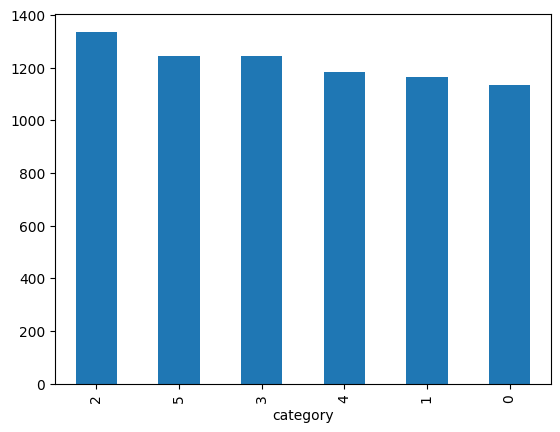

In [62]:
test_df["category"].value_counts().plot.bar()

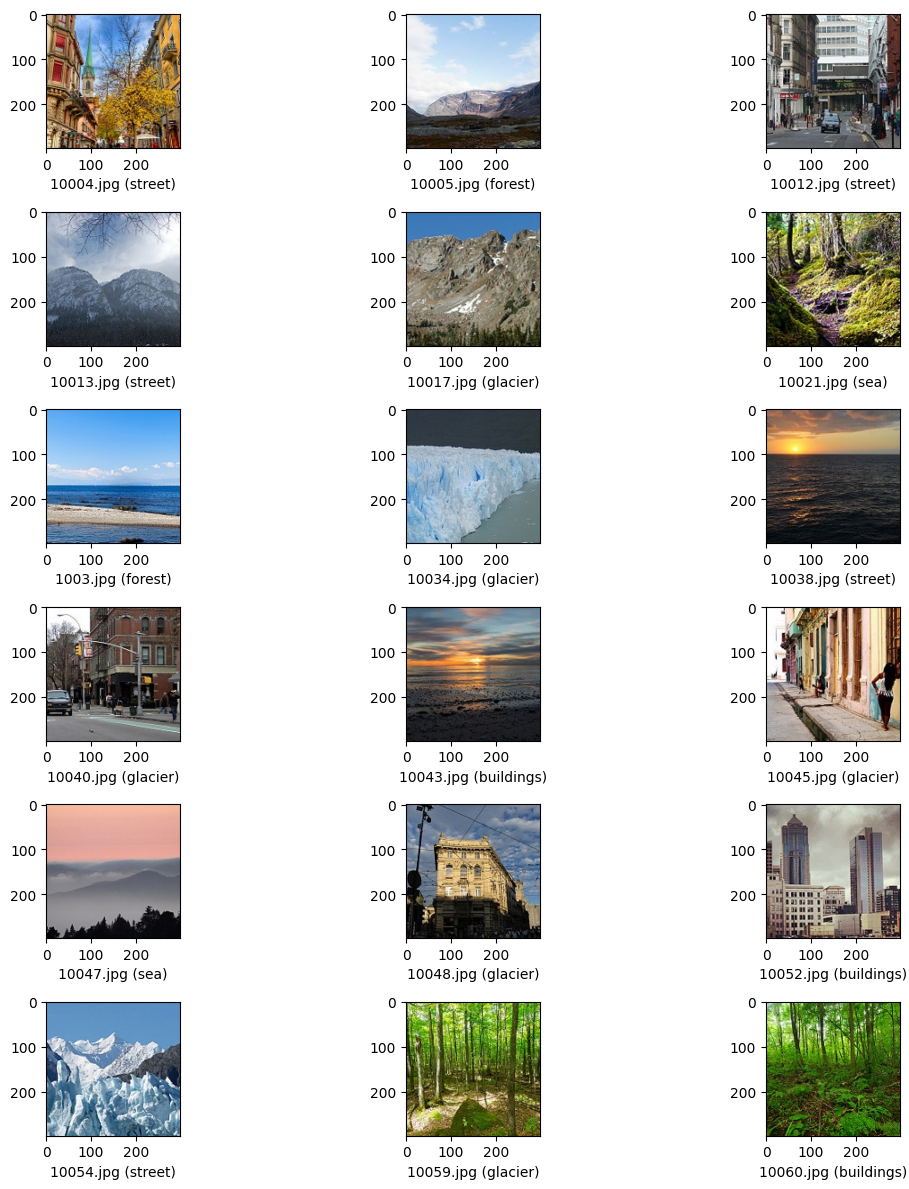

In [63]:
# Преобразование категорий в числовые значения
sample_test = test_df.head(18)
reverse_category_mapping = {v: k for k, v in CLASS_LABELS.items()}  # Создание обратного словаря
sample_test.loc[:, 'category'] = sample_test.loc[:, 'category'].replace(CLASS_LABELS)

plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img(TEST_DIRECTORY + filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + reverse_category_mapping[category] + ')')
plt.tight_layout()
plt.show()